# Chapter 27 of HS, Mineral Fuel, Oil, etc; Bitumin Subst; Mineral Wax Analysis

### Libraries

In [2]:
!pip3 install plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 34.3 MB/s eta 0:00:0000:0100:01


In [1]:
import requests
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from io import StringIO
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import zipfile
import os

### Datahandler class 
- deals with data, writing to and reading from CSV Files

In [2]:
class DataHandler:
    @staticmethod
    def to_parquet(dataframe, parquet_filename):
        # Create 'data' directory if it doesn't exist
        data_dir = os.path.join(os.getcwd(), 'data')
        os.makedirs(data_dir, exist_ok=True)

        # Writing dataframe to Parquet file within 'data' directory
        parquet_path = os.path.join(data_dir, parquet_filename)
        dataframe.to_parquet(parquet_path, index=False)

    @staticmethod
    def from_parquet(parquet_filename):
        # Reading Parquet file into a DataFrame
        parquet_path = os.path.join(os.getcwd(), 'data', parquet_filename)
        dataframe = pd.read_parquet(parquet_path)
        return dataframe


### Data Class 
- for Universal Objects

In [3]:
@dataclass
class data:
    I: object 
    E: object 

### TradeDataFilter class
- Filter to Extract Subsets

In [4]:
class TradeDataFilter:
    def __init__(self, data_frame):
        self.data_frame = data_frame

    @staticmethod
    def extract_state(dist_name):
        parts = dist_name.split(',')
        if len(parts) > 1:
            return parts[-1].strip()
        else:
            return dist_name

    def filter_data(self, **kwargs):
        filtered_data = self.data_frame.copy()

        for key, value in kwargs.items():
            if key == 'start_date':
                filtered_data = filtered_data[filtered_data['Date'] >= value]
            elif key == 'end_date':
                filtered_data = filtered_data[filtered_data['Date'] <= value]
            elif key in filtered_data.columns:
                if isinstance(value, list):
                    # Handle list values (e.g., for multiple commodities, countries, etc.)
                    filtered_data = filtered_data[filtered_data[key].isin(value)]
                else:
                    # Handle single value
                    filtered_data = filtered_data[filtered_data[key] == value]
            else:
                print(f"Warning: '{key}' column not found in data. Skipping filtering by this condition.")

        if filtered_data.empty:
            print("Error: Filtered data is empty.")
            return None
        else:
            return filtered_data.reset_index(drop=True)


### SankeyTradeAnalysis class
- computes the top importer and exporter partners countries of US and the hotspots (states) within US where these trades occur in high amounts, and then plots the flow analysis of International Trade of US with its partnering countries for chapter 27


In [5]:
class SankeyTradeAnalysis:
    def __init__(self, k=3, n=10):
        self.k = k
        self.n = n

    def compute_top_targets(self, dataFrame, country, source, destination, values):
        topk_countries = (dataFrame.groupby(country)[values].sum()
                          .nlargest(self.k).index)
        
        topk_data = dataFrame[dataFrame[country].isin(topk_countries)]
        
        result = (topk_data.groupby([source, destination])[values].sum()
                  .reset_index()
                  .groupby(country)
                  .apply(lambda x: x.nlargest(self.n, values))
                  .reset_index(drop=True))
        
        result.columns = ['source', 'target', 'values']
        result = result[result['values'] != 0]
        result['values'] = round(result['values'] / 1e9, 4)
        return result

    def map_nodes_and_create_links_dataframe(self, *dataframes):
        links = pd.concat(dataframes, axis=0)
        uniqueNodes = list(pd.unique(links[['source', 'target']].values.ravel('k')))
        mappedNodes = {k: v for v, k in enumerate(uniqueNodes)}
        links['source'] = links['source'].map(mappedNodes)
        links['target'] = links['target'].map(mappedNodes)
        linksDict = links.to_dict(orient='list')
        return uniqueNodes, linksDict


    def get_node_color(self, label):
        if label.endswith('(i)'):
            return "#a796e8"
        elif label.endswith('(e)'):
            return "#66023c"
        else:
            return "#66786c"

    def plot_sankey_diagram(self, uniqueNodes, linksDict, title):
        fig = go.Figure(data=[
            go.Sankey(
                    node=dict(
                        pad=10,
                        thickness=30,
                        line=dict(color="black", width=0.5),
                        label=uniqueNodes,
                        color=[self.get_node_color(label) for label in uniqueNodes],
                        line_width=0,
                    ),
                    link=dict(
                        source=linksDict['source'],
                        target=linksDict['target'],
                        value=linksDict['values'],
                        color="#ffcea5"
                    )
                ),
            
            #Custom Legend
            go.Scatter(
                x=[None],
                y=[None],
                mode="markers",
                name="Top Countries by Valuation that US Imported from",
                marker=dict(size=21, color="#a796e8", symbol='circle'),
            ),

            go.Scatter(
                x=[None],
                y=[None],
                mode="markers",
                name="Top Countries by Valuation that US Exported to",
                marker=dict(size=21, color="#66023c", symbol='circle'),
            ),

            go.Scatter(
                x=[None],
                y=[None],
                mode="markers",
                name="The US States, where International Trade Transactions occured",
                marker=dict(size=21, color="#66786c", symbol='circle'),
            )
        ])
        
        fig.update_layout(
            legend=dict(
                orientation="h", 
                y=-0.1,  
                x=0.5,   
                xanchor='center', 
                yanchor='top',    
                bgcolor='rgba(255, 255, 255, 0.7)', 
                bordercolor='rgba(0, 0, 0, 0.5)',      
                borderwidth=1,                         
            ),
            title_text=title,
            font_size=10,
            title_font_size=20,
            height=900,
            width=1200,
            paper_bgcolor='#c9ffc7',
            plot_bgcolor='#c9ffc7'
        )


        # Remove axis values
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)

        fig.show("svg")


    def performSankey(self, importDF, exportDF, title='default'):

        importsCTYtoUSDT = self.compute_top_targets(dataFrame=importDF,
                                                              country='CTYi',
                                                              source='CTYi',
                                                              destination='US_STATE',
                                                              values='GEN_VAL_MO')

        exportsUSDTtoCTY = self.compute_top_targets(dataFrame=exportDF,
                                                              country='CTYe',
                                                              source='US_STATE',
                                                              destination='CTYe',
                                                              values='ALL_VAL_MO')

        uniqueNodes, linksDict = self.map_nodes_and_create_links_dataframe(importsCTYtoUSDT, 
                                                                                     exportsUSDTtoCTY)

        self.plot_sankey_diagram(uniqueNodes=uniqueNodes, 
                                           linksDict=linksDict, 
                                           title=title)






### DonutChartCreator class
- will take imports or exports data as input and will return a donut chart of the top k countries or US States perfroming Imports or Exports accordingly

In [6]:
class DonutChartCreator:
    def __init__(self, data, value, loc):
        self.data = data
        self.value = value
        self.loc = loc
        
    
    def create_donut_chart(self, k=3, hole=0.6, title_suffix=""):
        df = self.data

        # Calculate import/export valuations for each location
        location_valuations = df.groupby(self.loc)[self.value].sum().reset_index()

        # Sort locations based on valuations
        sorted_locations = location_valuations.sort_values(by=self.value, ascending=False)

        # Select top k locations and sum the remaining valuations
        top_k_locations = sorted_locations.head(k)
        others_valuation = sorted_locations.iloc[k:][self.value].sum()

        # Create a new DataFrame with top k locations and the "others" category
        top_locations_and_others = pd.concat([top_k_locations,
                                              pd.DataFrame({self.loc: ['Others'], self.value: [others_valuation]})])

        # Create a donut chart
        fig = px.pie(top_locations_and_others, values=self.value, names=self.loc, hole=hole,
                     title=f'Top {k} {title_suffix}')

        # Customizing layout
        fig.update_traces(
            textinfo='percent+label',
            marker=dict(line=dict(color='#000000', width=2)),
            pull=[0.05] * (k + 1)  # Pulling slices for emphasis
        )
        
        # Update layout
        fig.update_layout(
            title=dict(font=dict(size=24, color='#000000')),  
            font=dict(size=14, color='#333333'), 
            paper_bgcolor='rgba(0,0,0,0)', 
            plot_bgcolor='rgba(0,0,0,0)',  
        )

        fig.show("svg")


### Time Series Visualiser Class 
- Plots time series data on an interactive UI

In [7]:
class TimeSeriesVisualizer:
    def __init__(self):
        pass
        
    def visualize_time_series(self, x, ys, xlabel, ylabels, title=''):
        fig = go.Figure()


        for y, label in zip(ys, ylabels):
            fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers', name=label))

        fig.update_layout(
            title=title,
            xaxis_title=xlabel,
            yaxis_title='Values',
            font=dict(size=14, color='#ffffff'),
            legend=dict(
                orientation='h', 
                yanchor='bottom',
                y=1.02,
                xanchor='right',
                x=1,
                bgcolor='rgba(0, 0, 0, 0.7)',  
                bordercolor='rgba(255, 255, 255, 0.5)',  
                borderwidth=1,                        
                font=dict(size=12, color='#ffffff'),   
                
            ),
                height= 600,
                width = 1000,
            plot_bgcolor='#1f1f1f', 
            paper_bgcolor='#1f1f1f', 
            xaxis=dict(
                gridcolor='#666666', 
                zerolinecolor='#666666' 
            ),
            yaxis=dict(
                gridcolor='#666666', 
                zerolinecolor='#666666'  
            )
        )

        # Show plot
        fig.show("svg")

### Fetching Data 

In [8]:

dh = DataHandler()
d = data(
            I = dh.from_parquet('ImportsData.parquet'),
            E = dh.from_parquet('ExportsData.parquet')
         )


ectypes = {
    'E_COMMODITY_SDESC' : str,
    'COMM_LVL' : str,
    'DISTRICT': int,
    'DIST_NAME': str,
    'CTY_CODE': int,
    'CTY_NAME': str,
    'ALL_VAL_MO':np.int64,
    'YEAR': int,
    'MONTH':int,
    'E_COMMODITY':np.int64,
    'SUMMARY_LVL': str,
    'SUMMARY_LVL2': str
}

ictypes = {
    'I_COMMODITY_SDESC' : str,
    'COMM_LVL' : str,
    'DISTRICT': int,
    'DIST_NAME': str,
    'CTY_CODE': int,
    'CTY_NAME': str,
    'GEN_VAL_MO':np.int64,
    'CON_VAL_MO':np.int64,
    'YEAR': int,
    'MONTH':int,
    'I_COMMODITY':np.int64,
    'SUMMARY_LVL': str,
    'SUMMARY_LVL2': str
}

# Convert data types accordingly
d.E = d.E.astype(ectypes)

# Convert data types accordingly
d.I = d.I.astype(ictypes)

d.I['US_STATE'] = d.I.DIST_NAME.apply(TradeDataFilter.extract_state)
d.E['US_STATE'] = d.E.DIST_NAME.apply(TradeDataFilter.extract_state)


d.I['CTYi'] = d.I.CTY_NAME.apply(lambda x: x + '(i)')
d.E['CTYe'] = d.E.CTY_NAME.apply(lambda x: x + '(e)')

d.I['Date'] = pd.to_datetime(d.I.YEAR.astype(str) + '-' + d.I.MONTH.astype(str), format='%Y-%m')
d.E['Date'] = pd.to_datetime(d.E.YEAR.astype(str) + '-' + d.E.MONTH.astype(str), format='%Y-%m')


fi = TradeDataFilter(d.I)
fe = TradeDataFilter(d.E)

## Flow Analysis

### Sankey or Alluvial Diagrams

- Sankey Diagram representing Internation Trade of US (top n states)
- The below plot shows Import/Exports of Chapter 27 from 2013 to 2023
- Hover on the plot to see valuations
- Flow shows Valuation of goods traded
- purple to dark green shows goods imported into a US State from that country
- Dark green to maroon shows goods exported from a US State into that country



## Sankey Chart (HS 27)

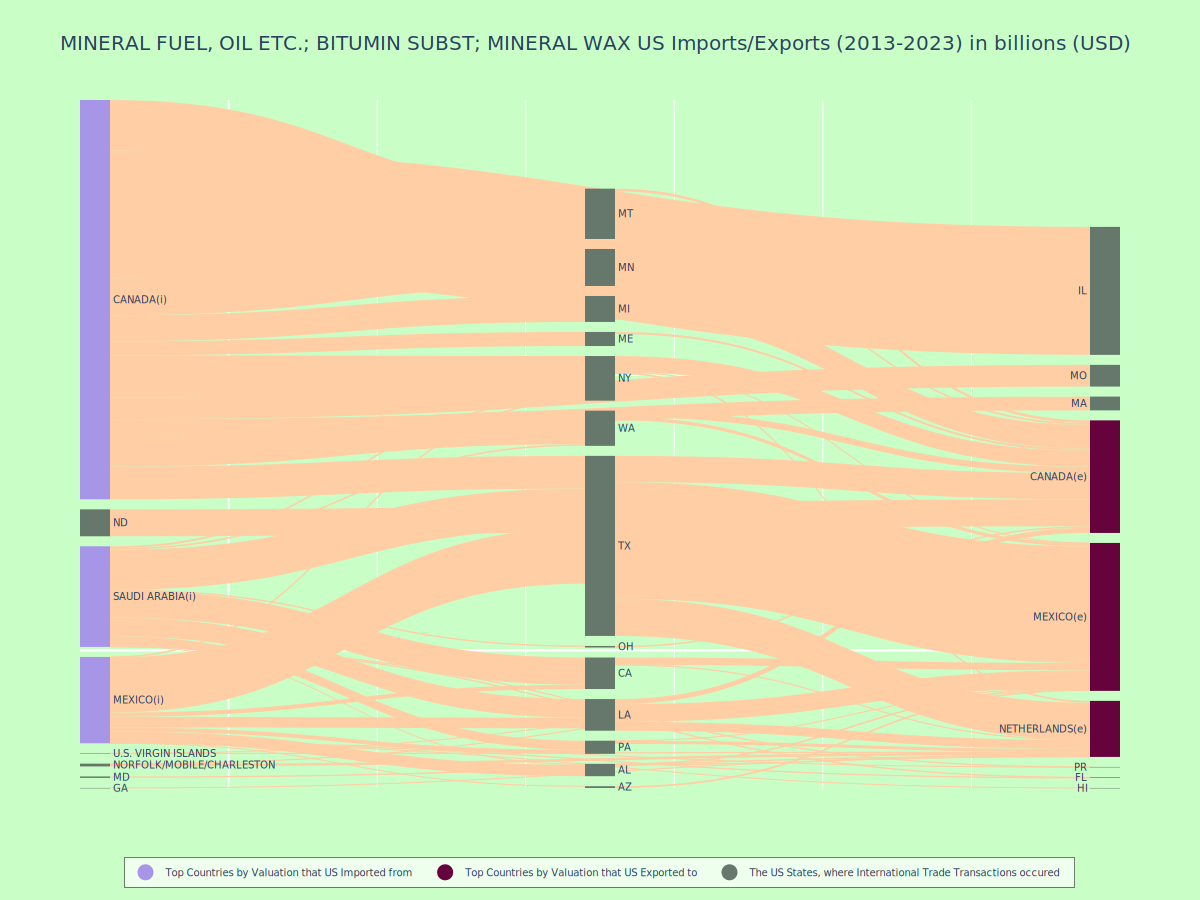

In [9]:

nStates = 10
kCountries = 3
HScode = 27


fi1 = fi.filter_data(I_COMMODITY = HScode)
fe1 = fe.filter_data(E_COMMODITY = HScode)


trade_analysis = SankeyTradeAnalysis(k=kCountries,
                                     n=nStates)
trade_analysis.performSankey(importDF=fi1, 
                             exportDF=fe1, 
                             title=fi1.at[0,'I_COMMODITY_SDESC'] + ' US Imports/Exports (2013-2023) in billions (USD)')


## Donut Chart (HS 27 by Country)

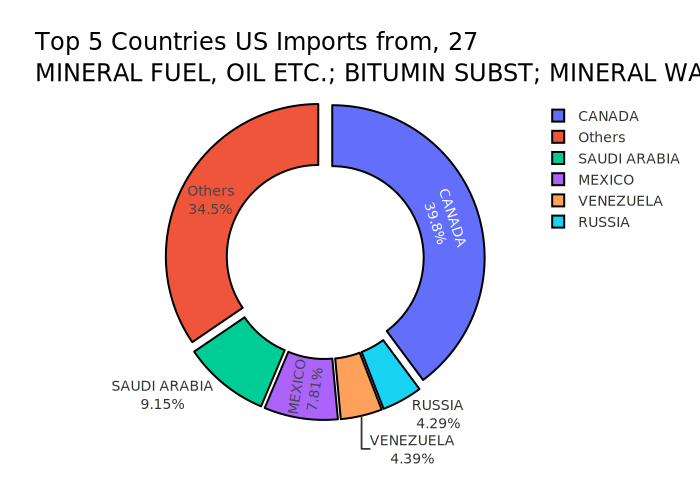

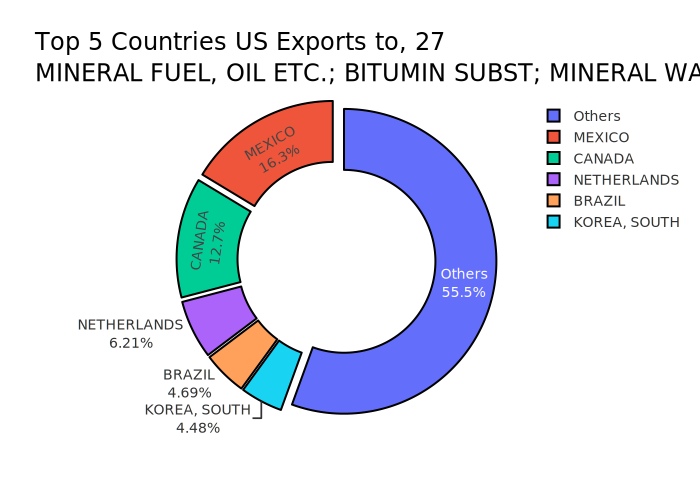

In [10]:
nStates = 5
kCountries = 5

# Top 5 Countries US imports HS 27 from
dCC = DonutChartCreator(data = fi1, value='GEN_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Imports from, {HScode} <br> {fi1.at[0,'I_COMMODITY_SDESC']}")


# # Top 5 countries US exports HS 27 to

dCC = DonutChartCreator(data = fe1, value='ALL_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Exports to, {HScode} <br> {fe1.at[0,'E_COMMODITY_SDESC']}")

## Donut Chart (HS 27 by State)

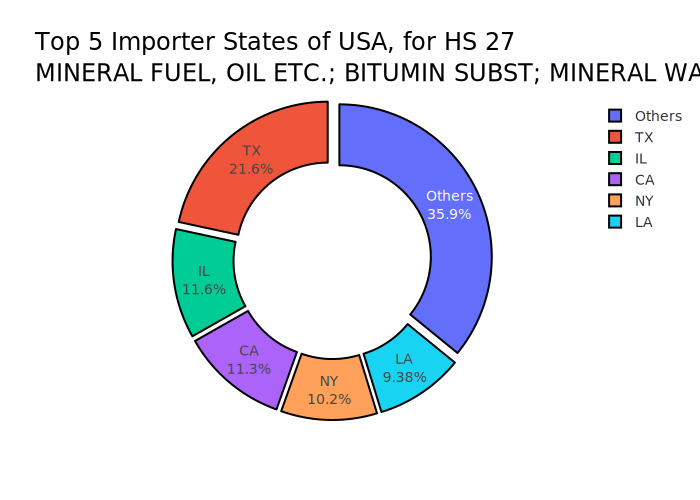

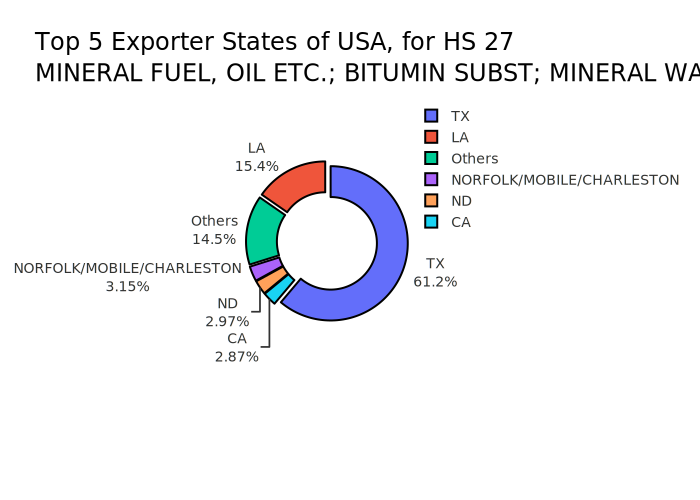

In [11]:
# Top 5 Countries US imports HS 27 from
dCC = DonutChartCreator(data = fi1, value='GEN_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Importer States of USA, for HS {HScode} <br> {fi1.at[0,'I_COMMODITY_SDESC']}")


# # Top 5 countries US exports HS 27 to

dCC = DonutChartCreator(data = fe1, value='ALL_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Exporter States of USA, for HS {HScode} <br> {fe1.at[0,'E_COMMODITY_SDESC']}")

## Sankey Chart (HS 2716000000): POWER

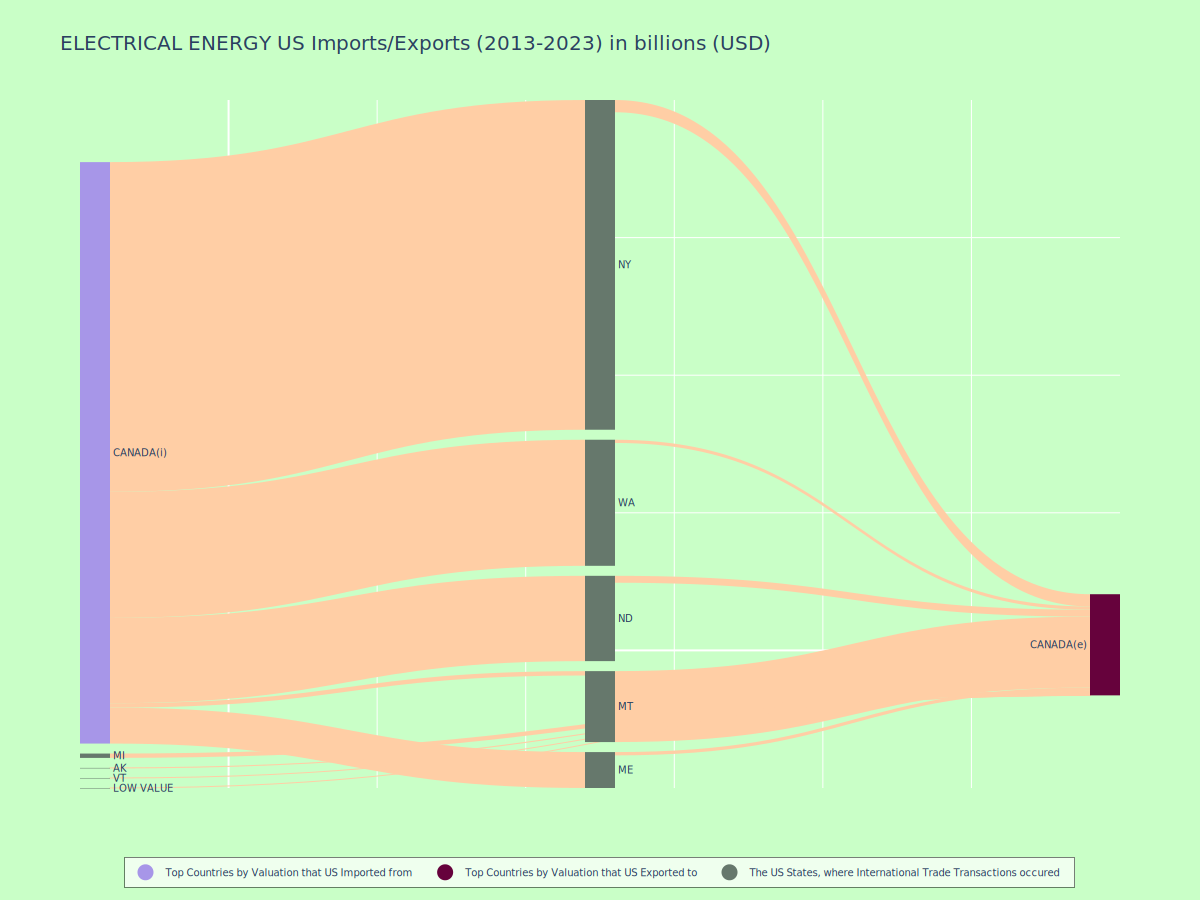

In [12]:

nStates = 10
kCountries = 3
HScode = 2716000000
fi2 = fi.filter_data(I_COMMODITY = HScode)
fe2 = fe.filter_data(E_COMMODITY = HScode)

trade_analysis = SankeyTradeAnalysis(k=kCountries,
                                     n=nStates)
trade_analysis.performSankey(importDF=fi2, 
                             exportDF=fe2, 
                             title=fi2.at[0,'I_COMMODITY_SDESC'] + ' US Imports/Exports (2013-2023) in billions (USD)')
                             



## Donut Chart (HS 2716000000): POWER, by Country

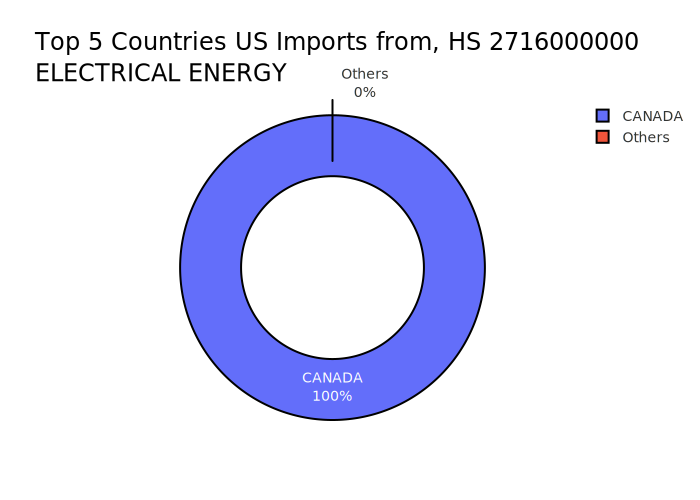

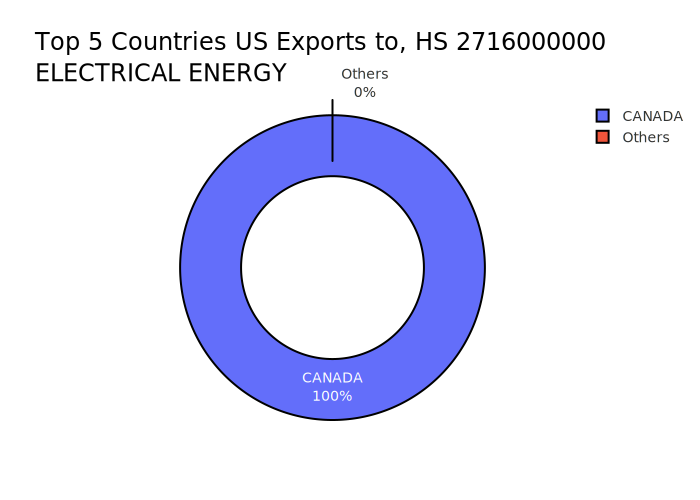

In [13]:
nStates = 5
kCountries = 5

# Top 5 Countries US imports HS 27 from
dCC = DonutChartCreator(data = fi2, value='GEN_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Imports from, HS {HScode} <br> {fi2.at[0,'I_COMMODITY_SDESC']}")


# # Top 5 countries US exports HS 27 to

dCC = DonutChartCreator(data = fe2, value='ALL_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Exports to, HS {HScode} <br> {fe2.at[0,'E_COMMODITY_SDESC']}")

## Donut Chart (HS 2716000000): POWER, by State

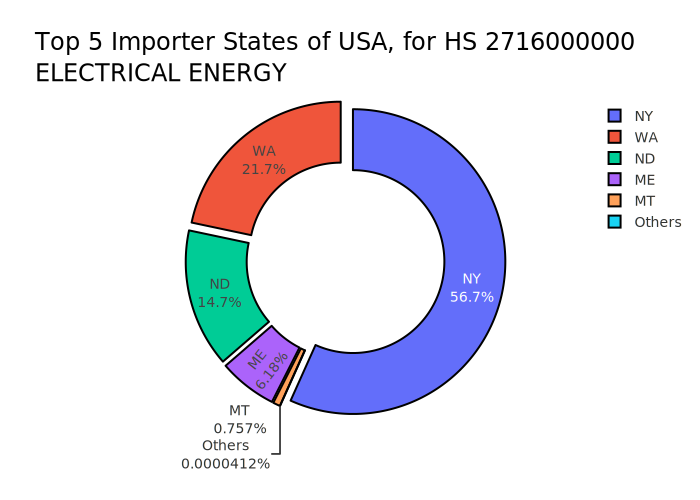

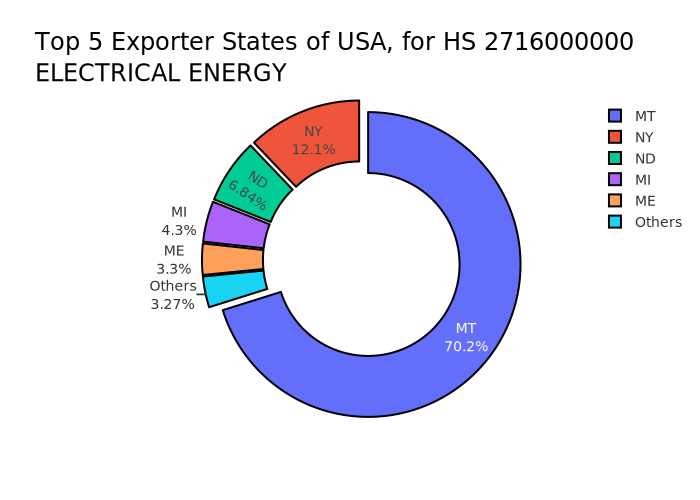

In [14]:
# Top 5 Countries US imports HS 27 from
dCC = DonutChartCreator(data = fi2, value='GEN_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Importer States of USA, for HS {HScode} <br> {fi2.at[0,'I_COMMODITY_SDESC']}")


# # Top 5 countries US exports HS 27 to
dCC = DonutChartCreator(data = fe2, value='ALL_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Exporter States of USA, for HS {HScode} <br> {fi2.at[0,'I_COMMODITY_SDESC']}")

## Sankey chart (HS 271111) , LNG (Liquified Natural Gas)

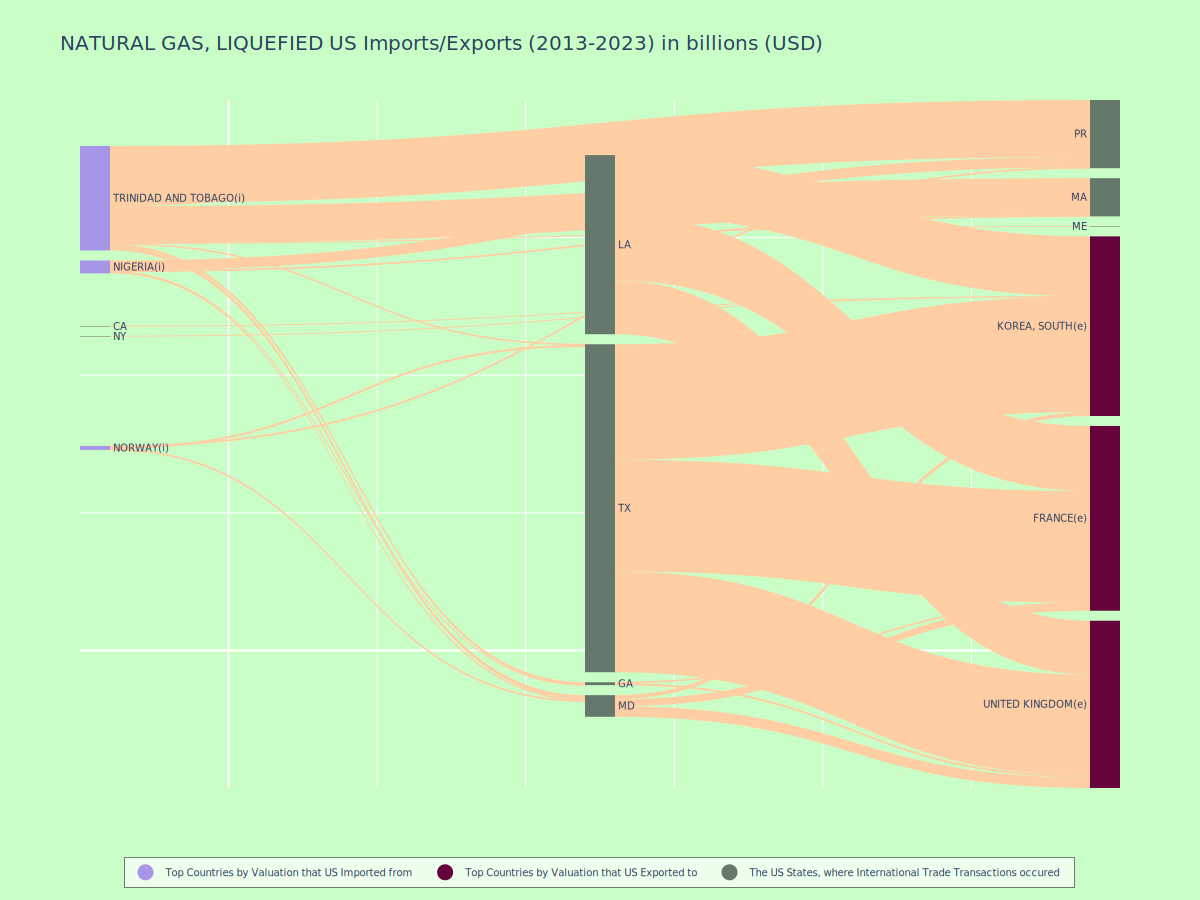

In [15]:

nStates = 10
kCountries = 3
HScode = 271111
fi3 = fi.filter_data(I_COMMODITY = HScode)
fe3 = fe.filter_data(E_COMMODITY = HScode)
trade_analysis = SankeyTradeAnalysis(k=kCountries,
                                     n=nStates)
trade_analysis.performSankey(importDF=fi3, 
                             exportDF=fe3,
                             title=fi3.at[0,'I_COMMODITY_SDESC'] + ' US Imports/Exports (2013-2023) in billions (USD)')
                            

## Donut Chart (HS 271111) , LNG (Liquified Natural Gas), by Country

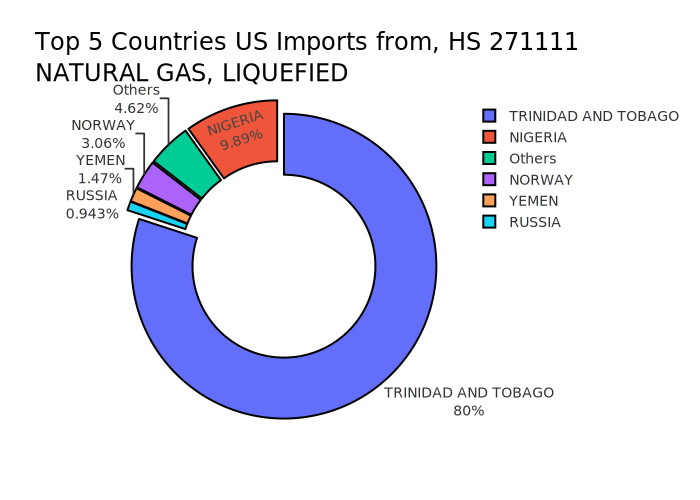

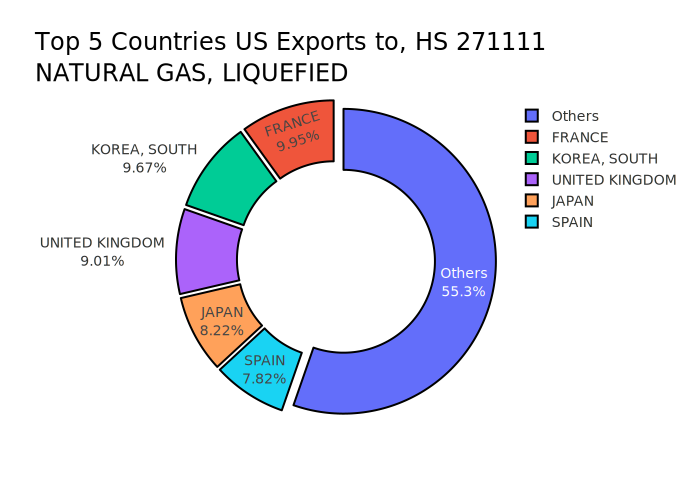

In [16]:


nStates = 5
kCountries = 5

# Top 5 Countries US imports HS 27 from
dCC = DonutChartCreator(data = fi3, value='GEN_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Imports from, HS {HScode} <br> {fi3.at[0,'I_COMMODITY_SDESC']}")


# # Top 5 countries US exports HS 27 to

dCC = DonutChartCreator(data = fe3, value='ALL_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Exports to, HS {HScode} <br> {fe3.at[0,'E_COMMODITY_SDESC']}")

## Donut Chart (HS 271111) , LNG (Liquified Natural Gas), by State

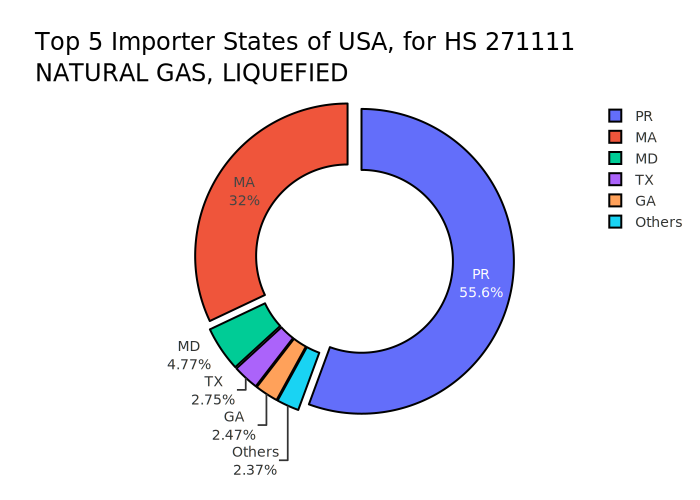

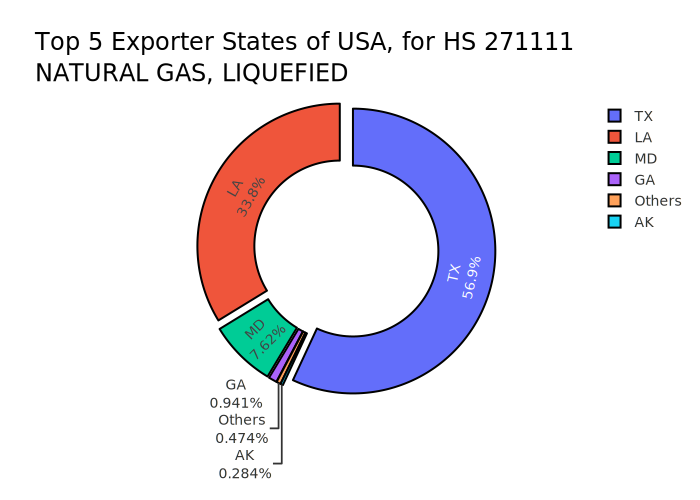

In [17]:
dCC = DonutChartCreator(data = fi3, value='GEN_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Importer States of USA, for HS {HScode} <br> {fi3.at[0,'I_COMMODITY_SDESC']}")


dCC = DonutChartCreator(data = fe3, value='ALL_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Exporter States of USA, for HS {HScode} <br> {fe3.at[0,'E_COMMODITY_SDESC']}")

In [18]:
27092000

27092000

## Sankey chart (HS 2709) , CRUDE OIL FROM PETROLEUM AND BITUMINOUS MINERALS

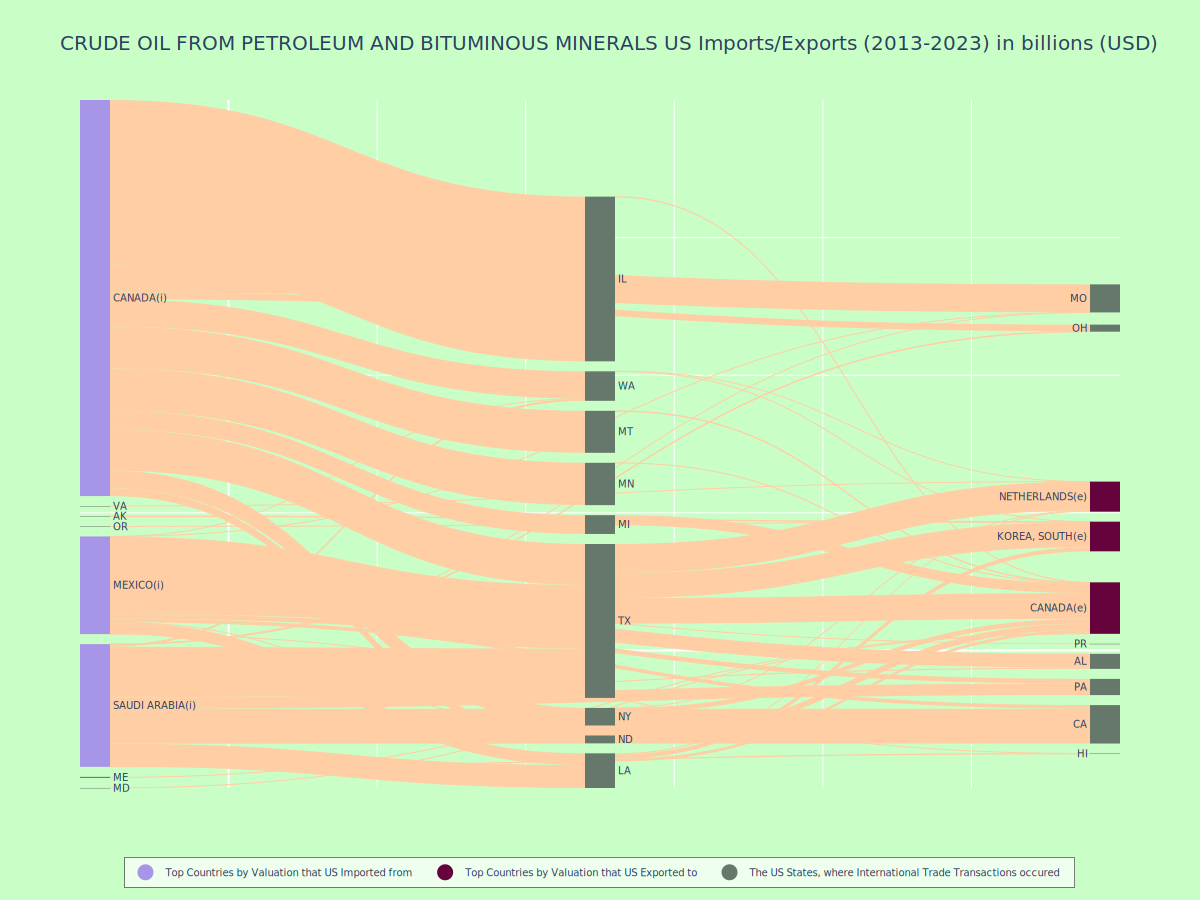

In [19]:

nStates = 10
kCountries = 3
HScode = 2709
fi31 = fi.filter_data(I_COMMODITY = HScode)
fe31 = fe.filter_data(E_COMMODITY = HScode)
trade_analysis = SankeyTradeAnalysis(k=kCountries,
                                     n=nStates)
trade_analysis.performSankey(importDF=fi31, 
                             exportDF=fe31,
                             title=fi31.at[0,'I_COMMODITY_SDESC'] + ' US Imports/Exports (2013-2023) in billions (USD)')
                            

## Donut Chart (HS 2709) , CRUDE OIL FROM PETROLEUM AND BITUMINOUS MINERALS by Country

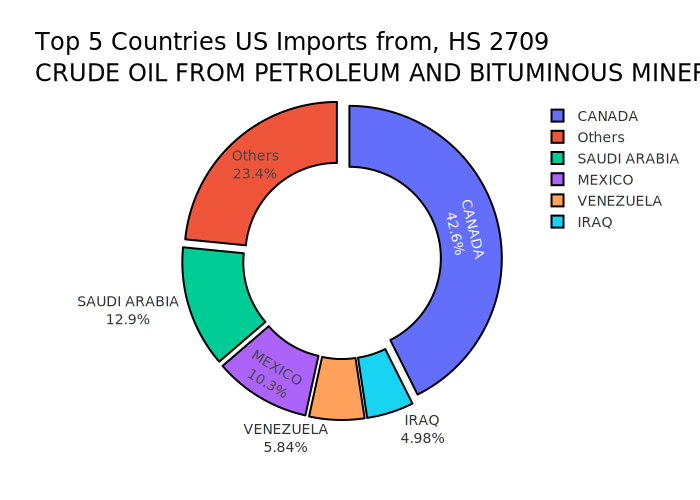

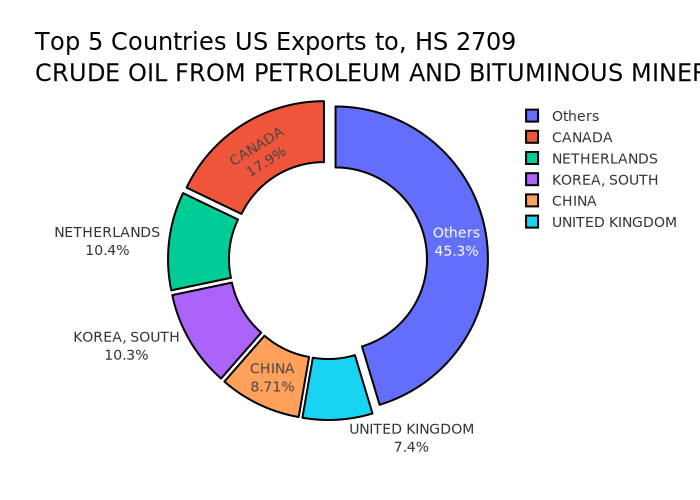

In [20]:
nStates = 5
kCountries = 5

dCC = DonutChartCreator(data = fi31, value='GEN_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Imports from, HS {HScode} <br> {fi31.at[0,'I_COMMODITY_SDESC']}")



dCC = DonutChartCreator(data = fe31, value='ALL_VAL_MO', loc='CTY_NAME')
dCC.create_donut_chart(k=kCountries, title_suffix=f"Countries US Exports to, HS {HScode} <br> {fe31.at[0,'E_COMMODITY_SDESC']}")

## Donut Chart (HS 2709) , CRUDE OIL FROM PETROLEUM AND BITUMINOUS MINERALS by State

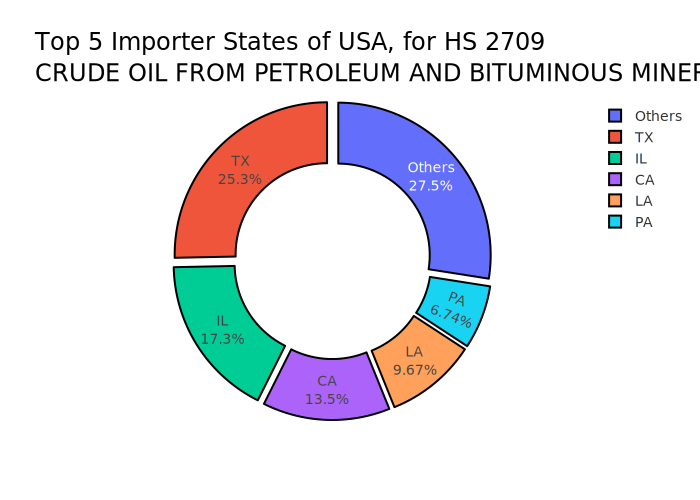

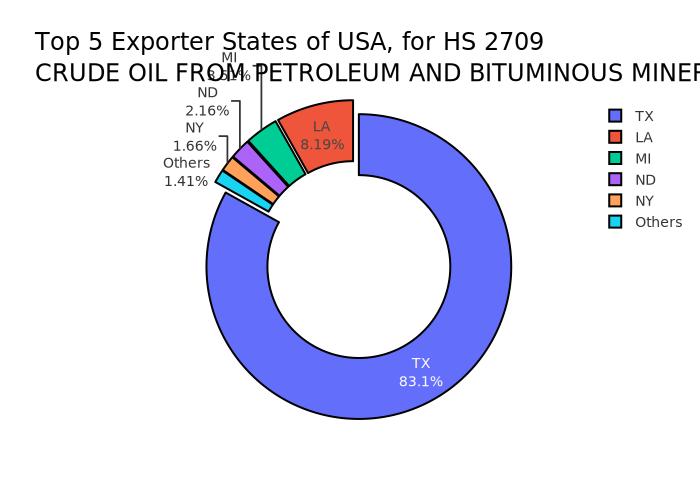

In [21]:
dCC = DonutChartCreator(data = fi31, value='GEN_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Importer States of USA, for HS {HScode} <br> {fi31.at[0,'I_COMMODITY_SDESC']}")


dCC = DonutChartCreator(data = fe31, value='ALL_VAL_MO', loc='US_STATE')
dCC.create_donut_chart(k=nStates, title_suffix=f"Exporter States of USA, for HS {HScode} <br> {fe31.at[0,'E_COMMODITY_SDESC']}")

## Time Series Charts

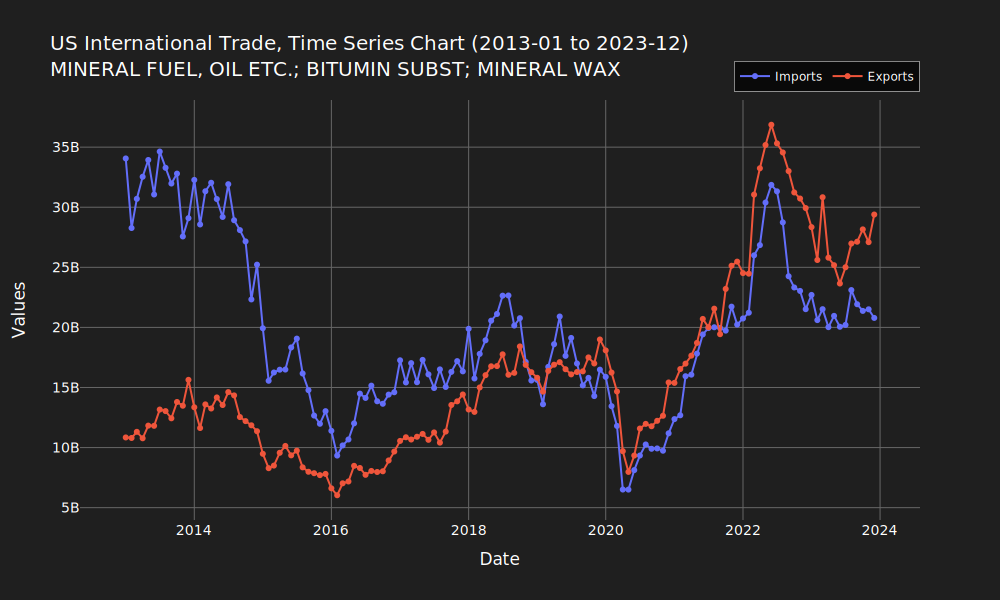

In [22]:
sDate = pd.to_datetime('2013-01-01')
eDate = pd.to_datetime('2023-12-31')

HScode = 27

fi4 = fi.filter_data(I_COMMODITY=HScode, start_date= sDate, end_date= eDate)
fe4 = fe.filter_data(E_COMMODITY=HScode, start_date= sDate, end_date= eDate)


fImports = fi4.groupby(['Date'])['GEN_VAL_MO'].sum().reset_index()
fExports = fe4.groupby(['Date'])['ALL_VAL_MO'].sum().reset_index()
chartTitle = f'US International Trade, Time Series Chart ({str(sDate.date())[:-3]} to {str(eDate.date())[:-3]}) <br> { fi4.at[0,"I_COMMODITY_SDESC"] }'      

# Create an instance of TimeSeriesVisualizer for Imports
visualizer = TimeSeriesVisualizer()

# # Visualize time series graph
visualizer.visualize_time_series(x = fImports.Date,
                                 ys = [fImports.GEN_VAL_MO, fExports.ALL_VAL_MO],
                                 xlabel = 'Date',
                                 ylabels = ['Imports', 'Exports'],
                                 title=chartTitle)


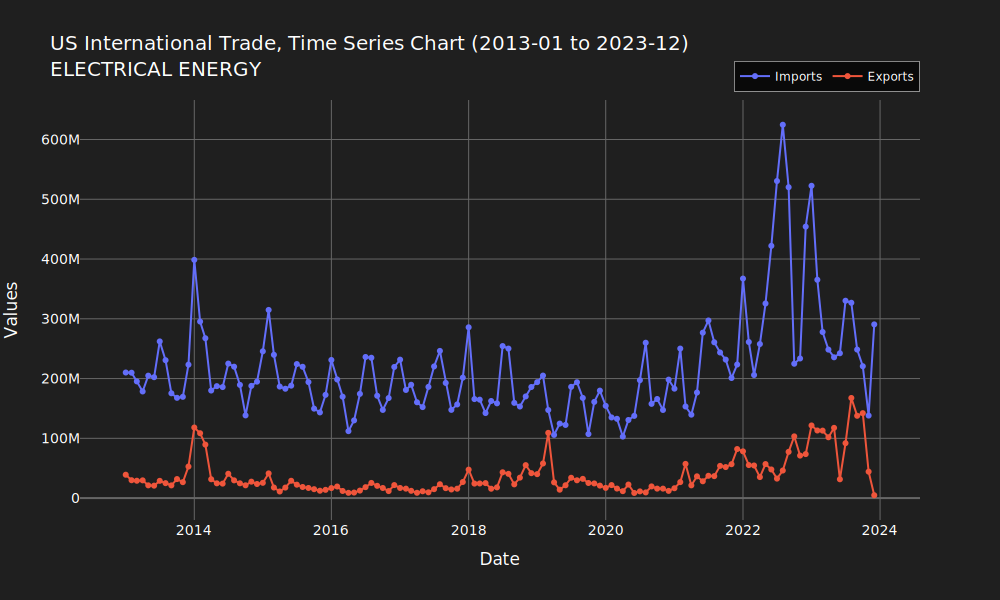

In [23]:
sDate = pd.to_datetime('2013-01-01')
eDate = pd.to_datetime('2023-12-31')

HScode = 2716000000

fi4 = fi.filter_data(I_COMMODITY=HScode, start_date= sDate, end_date= eDate)
fe4 = fe.filter_data(E_COMMODITY=HScode, start_date= sDate, end_date= eDate)


fImports = fi4.groupby(['Date'])['GEN_VAL_MO'].sum().reset_index()
fExports = fe4.groupby(['Date'])['ALL_VAL_MO'].sum().reset_index()
chartTitile = f'US International Trade, Time Series Chart ({str(sDate.date())[:-3]} to {str(eDate.date())[:-3]}) <br> { fi4.at[0,"I_COMMODITY_SDESC"] }'      

# Create an instance of TimeSeriesVisualizer for Imports
visualizer = TimeSeriesVisualizer()

# # Visualize time series graph
visualizer.visualize_time_series(x = fImports.Date,
                                 ys = [fImports.GEN_VAL_MO, fExports.ALL_VAL_MO],
                                 xlabel = 'Date',
                                 ylabels = ['Imports', 'Exports'],
                                 title=chartTitile)


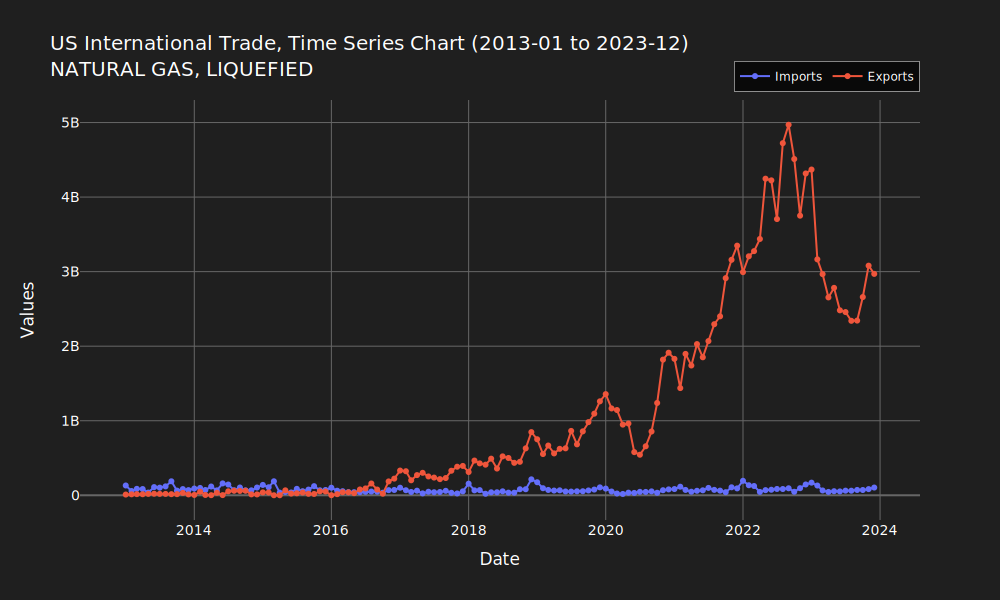

In [24]:
sDate = pd.to_datetime('2013-01-01')
eDate = pd.to_datetime('2023-12-31')

HScode = 271111

fi4 = fi.filter_data(I_COMMODITY=HScode, start_date= sDate, end_date= eDate)
fe4 = fe.filter_data(E_COMMODITY=HScode, start_date= sDate, end_date= eDate)


fImports = fi4.groupby(['Date'])['GEN_VAL_MO'].sum().reset_index()
fExports = fe4.groupby(['Date'])['ALL_VAL_MO'].sum().reset_index()
chartTitile = f'US International Trade, Time Series Chart ({str(sDate.date())[:-3]} to {str(eDate.date())[:-3]}) <br> { fi4.at[0,"I_COMMODITY_SDESC"] }'      

# Create an instance of TimeSeriesVisualizer for Imports
visualizer = TimeSeriesVisualizer()

# # Visualize time series graph
visualizer.visualize_time_series(x = fImports.Date,
                                 ys = [fImports.GEN_VAL_MO, fExports.ALL_VAL_MO],
                                 xlabel = 'Date',
                                 ylabels = ['Imports', 'Exports'],
                                 title=chartTitile)


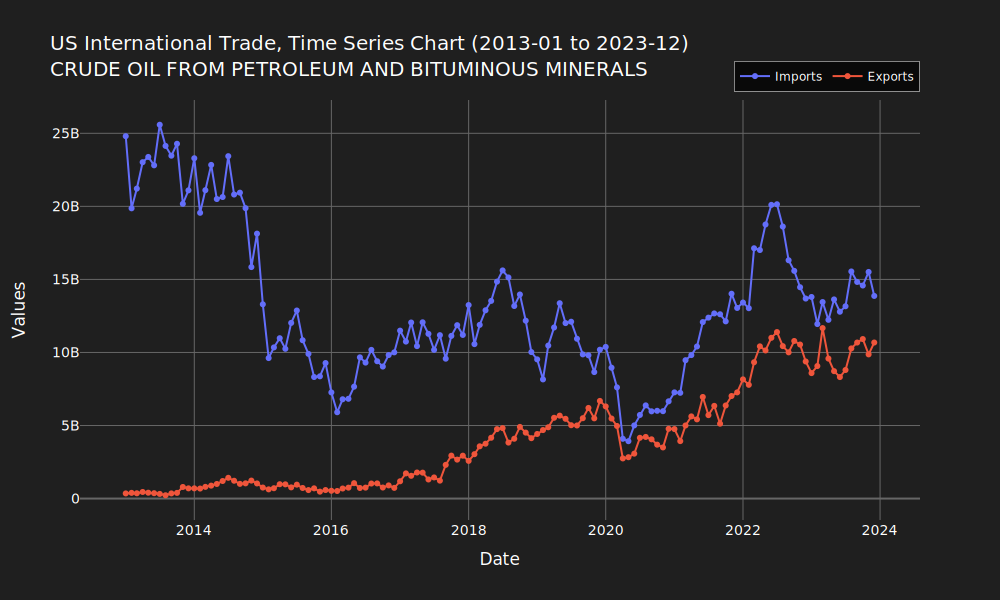

In [25]:
sDate = pd.to_datetime('2013-01-01')
eDate = pd.to_datetime('2023-12-31')

HScode = 2709

fi4 = fi.filter_data(I_COMMODITY=HScode, start_date= sDate, end_date= eDate)
fe4 = fe.filter_data(E_COMMODITY=HScode, start_date= sDate, end_date= eDate)


fImports = fi4.groupby(['Date'])['GEN_VAL_MO'].sum().reset_index()
fExports = fe4.groupby(['Date'])['ALL_VAL_MO'].sum().reset_index()
chartTitile = f'US International Trade, Time Series Chart ({str(sDate.date())[:-3]} to {str(eDate.date())[:-3]}) <br> { fi4.at[0,"I_COMMODITY_SDESC"] }'      

# Create an instance of TimeSeriesVisualizer for Imports
visualizer = TimeSeriesVisualizer()

# # Visualize time series graph
visualizer.visualize_time_series(x = fImports.Date,
                                 ys = [fImports.GEN_VAL_MO, fExports.ALL_VAL_MO],
                                 xlabel = 'Date',
                                 ylabels = ['Imports', 'Exports'],
                                 title=chartTitile)
